In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import time as t

from bs4 import BeautifulSoup as bs
import re
import nltk
import sklearn

In [4]:
# load the data  - 6 ml data points, takes a while to read
start = t.time()
train = pd.read_csv("train.csv")
print("Took {} minutes to load.".format(t.time()-start))

Took 630.7031440734863 minutes to load.


In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.Tags.value_counts()

In [ ]:
# sampling data for faster processing
train_set = train.sample(n=50000, random_state=42)


In [ ]:
train_set.info()

In [3]:
train_set.Tags.value_counts()

NameError: name 'train_set' is not defined

In [9]:
train_set.head()

,Id,Title,Body,Tags
779393,779394,LINQ Left Join On Not Equal Rows,<p>Im trying to display rows which does not ex...,linq join inequality
4988336,4988337,SSL Cert Client Validation - How to?,<p>We're setting up a VIP using F5 load balanc...,shell unix ssl ssl-certificate client-certific...
5207700,5207701,How to get MGSplitViewController working in Mo...,<p>I downloaded the MGSplitViewController proj...,iphone xcode binding monotouch simulator
5989550,5989551,"Writing my first gtk program, what's the best ...","<p>I've been reading tutorials, but one thing ...",gtk glade
1847890,1847891,Wordpress 2.8 Widget API is suitable for Worpr...,"<p>I am a little confused, the Wordpress 2.8 W...",plugin-development wordpress-version


In [10]:
# peek into data
train_set.Title.iloc[1:4]
train_set.Body.iloc[1]

# From the value counts and the title & body, it looks like the texts are about industry and technology

'<p>We\'re setting up a VIP using F5 load balancer in Windows 2008 Server. My IT dept has setup this VPI URL <a href="https://mydomain.com" rel="nofollow">https://mydomain.com</a> &amp; I need to test below scenarios but not sure how to do it?</p>\n\n<pre><code>SSL termination should happen for all requests.\nShould reject/drop the request if client SSL does not match.\nForward the request to my application, if client SSL matches.\n</code></pre>\n\n<p>Badically, the certificate is configured on Load balancer in such a way that LB will reject the request if client SSL does not match &amp; it\'ll accept it only if client SSL matches. </p>\n\n<p>Can any one tell me how to test this using some shell script or other way?</p>\n\n<p>Thanks!</p>\n'

In [12]:
#train_set.Title + " " + train_set.Body

In [13]:
# Data preprocessing 

print("before dropping duplicates: {}".format(len(train_set)))

# drop duplicates
train_set = train_set.drop_duplicates(subset=None, keep='first', inplace=False)

print("after dropping duplicates: {}".format(len(train_set)))

before dropping duplicates: 50000
after dropping duplicates: 50000


In [14]:
# clean html tags

def get_post(series):
    try:
        #get title
#         test_title = dataframe.Title

        # get body
#         test_body = dataframe.Body

        #get post 
#         dataframe['post'] = test_title + " " + test_body

        #clean post
        series = series.apply(lambda x: bs(markup=x, features='html.parser').getText())
    #     post = soup.getText()

        # remove symbols with regex
        series = series.apply(lambda x: re.sub(r"[^a-zA-Z0-9]"," ", x))
        series = series.apply(lambda x: x.replace('\n', ' '))
        
    #     post = re.sub(r"[^a-zA-Z0-9]", " ", post)
    except (TypeError, IndexError):
        print('typeerror')

    return series


In [15]:
train_set['cleaned_body'] = get_post(train_set.Body)

In [16]:
train_set.cleaned_body.iloc[:5]

779393     Im trying to display rows which does not exist...
4988336    We re setting up a VIP using F5 load balancer ...
5207700    I downloaded the MGSplitViewController project...
5989550    I ve been reading tutorials  but one thing I m...
1847890    I am a little confused  the Wordpress 2 8 Widg...
Name: cleaned_body, dtype: object

In [19]:
# tokenization 
tokenizer = nltk.WordPunctTokenizer()

# word count 
train_set['word count'] = train_set.cleaned_body.apply(lambda x: len(tokenizer.tokenize(x)))

In [20]:
train_set.head()

,Id,Title,Body,Tags,cleaned_body,word count
779393,779394,LINQ Left Join On Not Equal Rows,<p>Im trying to display rows which does not ex...,linq join inequality,Im trying to display rows which does not exist...,136
4988336,4988337,SSL Cert Client Validation - How to?,<p>We're setting up a VIP using F5 load balanc...,shell unix ssl ssl-certificate client-certific...,We re setting up a VIP using F5 load balancer ...,116
5207700,5207701,How to get MGSplitViewController working in Mo...,<p>I downloaded the MGSplitViewController proj...,iphone xcode binding monotouch simulator,I downloaded the MGSplitViewController project...,70
5989550,5989551,"Writing my first gtk program, what's the best ...","<p>I've been reading tutorials, but one thing ...",gtk glade,I ve been reading tutorials but one thing I m...,112
1847890,1847891,Wordpress 2.8 Widget API is suitable for Worpr...,"<p>I am a little confused, the Wordpress 2.8 W...",plugin-development wordpress-version,I am a little confused the Wordpress 2 8 Widg...,38


In [21]:
train_set.Tags.value_counts()

android                                          405
php                                              256
javascript jquery                                214
javascript                                       210
jquery                                           209
c#                                               193
java                                             192
python                                           157
c++                                              141
php mysql                                        132
html css                                         123
mysql                                            120
iphone                                            98
c# asp.net                                        86
css                                               80
asp.net                                           79
java android                                      78
ruby-on-rails                                     72
c                                             

In [23]:
# lemmatizaion 

lemma = nltk.WordNetLemmatizer()

train_set["lemmatized_text"] = train_set.cleaned_body.apply(lambda x: lemma.lemmatize(x))

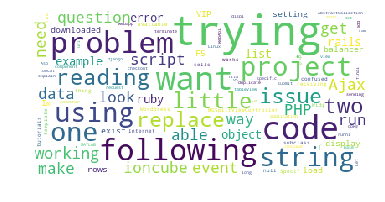

In [27]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(background_color='white',
                      stopwords=stopword_list,
                      max_words=100,
                      max_font_size=50,
                      random_state=42).generate(str(train_set.cleaned_body))


print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [30]:
# feature extraction 

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8, 
                         stop_words=stopword_list, 
                         max_features=1000,
                        ngram_range=(1,3))

tf_idf.fit(train_set.cleaned_body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=1000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'more', 'or', "hasn't", 'this', 'before', 'be', 'couldn', 'needn', 's', 'ourselves', 'there', 'a', 'nor', 'o', 'were', 'where', 'i', 'their', 'our', 'it', 'y', 'doesn', 'only', 'yours', 'm', 've', "hadn't", 'did', 'myself', "it's", 'all', 'now', 'the', 'she', "she's", 'same', 'over', 'ar...cause', "isn't", 'out', 'about', 'you', 'been', "you'll", 'will', 'had', 'isn', 'won', 'has', 'his'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [35]:
doc = pd.Series(train_set.cleaned_body[:500])
doc_vector = tf_idf.transform(doc)

In [43]:
type(doc)

pandas.core.series.Series

In [40]:
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 

In [44]:
doc.iloc[0]

'Im trying to display rows which does not exist from the other table using LINQ  can anyone help me  Here is the sql im using  select   from table1  left join table2 on  table1 col1   table2 col1  and  table1 col2   table2 col2 where table2 col1 is null and table2 col2 is null  Already searched and found some solution  Here is what i did so far  from t1 in table1 where    from t2 in table1   join t3 in table2 on   new   t2 col1  t2 col2      equals    new   t3 col1  t3 col2     select t2 PK  Contains t1 PK    select t1  The above code works well but im just wondering if that is the only solution i can use  I mean  instead of using JOIN and CONTAINS method  can t we use left join linq directly with a where clause  '

In [45]:
for k in keywords:
    print(k, keywords[k])

date 0.97
template 0.907
group 0.884
xsl 0.877
lib 0.877


reference: https://www.kaggle.com/tooezy/basic-keyword-extraction/notebook